## **dataframes**

voy a tratar de hacer un dataframe para aplicar algún tipo de clustering

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import sys
import scipy.signal as signal

import sys

sys.path.append('../data')
from data import load_data

sns.set_style("darkgrid")

In [3]:
# Load data
fpath = "C:/Users/consu/OneDrive/Documentos/GitHub/Tesis/data"

mat = load_data(fpath, 'datosconsu_021023_bajos.mat')

In [4]:
df = pd.DataFrame(mat['data'], columns = ['amp'])
df['amp_mean'] = df.amp - df.amp.mean()
df['dif'] = df.amp_mean.diff()
df.tail()

,amp,amp_mean,dif
599995,5.210999,-0.843661,-0.112124
599996,5.063692,-0.990968,-0.147307
599997,5.012726,-1.041933,-0.050966
599998,4.868050,-1.186610,-0.144676
599999,4.806563,-1.248097,-0.061487


In [5]:
# filtro pasa banda
order = 1
cutoff_freq = [9/1000, 11/1000]
b,a = signal.butter(order, cutoff_freq, btype='bandpass')

df_filtered = signal.filtfilt(b, a, df.amp_mean)

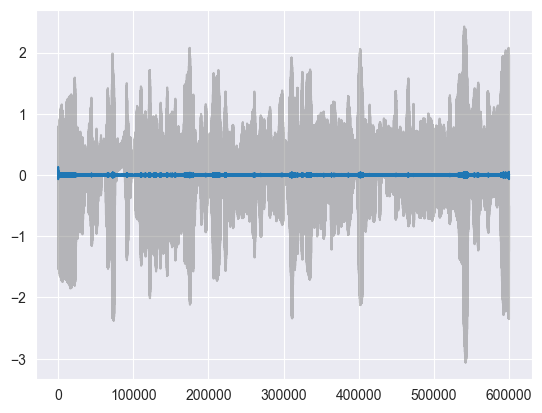

In [6]:
plt.plot(df.amp_mean, color = 'grey', alpha = 0.5)
plt.plot(df_filtered)
plt.show()

In [7]:
df_window = np.array_split(df_filtered, 100)
df_window =np.array(df_window)
df_window.shape

(100, 6000)

### **fase instantanea**
Se calcula la fase instantanea de toda la señal, dado que el cambio de fase es una serie de tiempo, por lo que no es necesario calcularlo para cada ventana.

In [8]:
# filtro de hilbert
s_filt =  signal.hilbert(df_filtered)
amp_envelope_filt = np.abs(s_filt)
inst_phase_filt =  np.unwrap(np.angle(s_filt))
inst_freq_filt = (np.diff(inst_phase_filt)/(2.0*np.pi) * 1000)
diff_phase =  np.diff(inst_phase_filt)
diff_phase = np.insert(diff_phase, 0, 0) #agrego un cero en el primer coeficiente

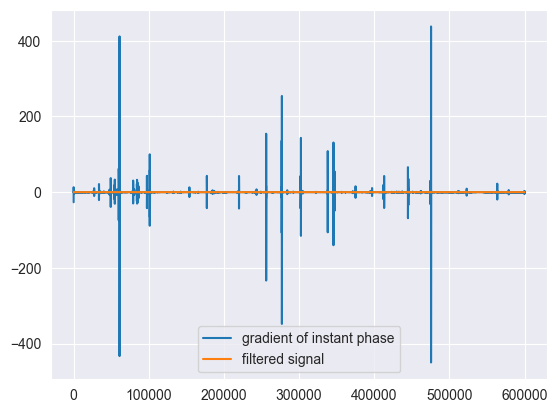

In [9]:
plt.plot(np.diff(inst_freq_filt), label = 'gradient of instant phase')
plt.plot(df_filtered, label = 'filtered signal')
plt.legend()
plt.show()

Se separa el array en 100 arreglos de 6000 muestras cada uno para hacer un dataset con los elementops y hacer clusterings

In [10]:
window_phase = np.array_split(diff_phase, 100)
window_phase =np.array(window_phase)
window_phase.shape

(100, 6000)

In [11]:
# son 100 ventanas (columnas) con 6.000 datos (filas)
df_phase = pd.DataFrame(window_phase)#.transpose()
df_phase.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.000000,0.182185,0.014910,0.097034,0.018271,0.074986,0.020442,0.064658,0.022024,0.058587,...,0.064932,0.064834,0.065173,0.065102,0.065411,0.065395,0.065646,0.065653,0.065826,0.065845
1,0.065954,0.066010,0.066044,0.066121,0.066097,0.066224,0.066142,0.066287,0.066144,0.066326,...,0.065675,0.065568,0.065641,0.065565,0.065596,0.065529,0.065525,0.065469,0.065442,0.065414
2,0.065353,0.065320,0.065209,0.065161,0.064997,0.064969,0.064803,0.064814,0.064640,0.064649,...,0.065739,0.065759,0.065897,0.065897,0.065995,0.066005,0.066081,0.066081,0.066126,0.066146
3,0.066173,0.066197,0.066209,0.066237,0.066209,0.066236,0.066182,0.066213,0.066131,0.066132,...,0.064590,0.064624,0.064771,0.064825,0.064961,0.065071,0.065214,0.065338,0.065446,0.065556
4,0.065622,0.065770,0.065838,0.065994,0.066020,0.066164,0.066147,0.066290,0.066246,0.066379,...,0.066385,0.066330,0.066602,0.066572,0.066813,0.066765,0.067035,0.066999,0.067227,0.067189


### **clustering**

Primero intentamos con kmeans y un scaler (MaxAbsScaler) para normalizar los datos, tengo nque probar con otro tipo de scalers tmbn (buscar los mejores)

#### **Static clustering con kmeans**

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

norm =  MinMaxScaler()
kmeans =  KMeans(n_clusters=5, random_state=0)

In [13]:
#scaled = norm.fit_transform(df_phase)
#kmeans.fit(scaled)
kmeans.fit(df_phase)
labels = kmeans.predict(df_phase)

In [14]:
labels = pd.DataFrame(labels, columns = ['labels'])
labels.value_counts()

labels
0         96
1          1
2          1
3          1
4          1
dtype: int64

In [15]:
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster}")
    cluster_data = df_phase[kmeans.labels_ == cluster]
    for i in range(min(5, cluster_data.shape[0])):
        print(cluster_data.index[i])
    print()

Cluster 0
0
1
2
3
4

Cluster 1
14

Cluster 2
50

Cluster 3
10

Cluster 4
79



In [16]:
from sklearn.metrics import silhouette_score
for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    kmeans.fit(df_phase)
    print(n_cluster, silhouette_score(df_phase, kmeans.labels_))

2 0.6249714582326689
3 0.6204833655941735
4 0.48466295667094145
5 0.5225738018865959
6 0.5268241391691708
7 0.40865215205242045
8 0.5271038482502624
9 0.5275655618029333


conclusion: no es bueno, realmente.

#### **dinamic time-warping**

In [18]:
from tslearn.clustering import TimeSeriesKMeans

km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km.fit(df_phase)

MemoryError: Unable to allocate 275. MiB for an array with shape (6000, 6000) and data type float64